In [3]:
# Load default images to memory

import os

import matplotlib.pyplot as plt

image_paths = [os.path.join(os.getcwd(), os.pardir, 'database', 'default_files', fname) for fname in os.listdir(os.path.join(os.pardir, 'database', 'default_files'))]

In [4]:
# read to disk
image_matrices = [plt.imread(path) for path in image_paths]

# add z-dimension to matrices

In [5]:
i = image_matrices[0]
i.shape

(1080, 1920, 3)

In [7]:
import numpy as np
import pandas as pd

def _split_into_rgb(i) -> tuple:
    ir = i[:, :, 0]
    ig = i[:, :, 1]
    ib = i[:, :, 2]
    return ir, ig, ib


def _marshal_to_point_form(im_slice, rgb, z) -> pd.DataFrame:
    points = []
    for y in range(im_slice.shape[0]):
        row = im_slice[y, :]
        pts = [(x, y, z, rgb, val) for x, val in enumerate(row)]
        points.extend(pts)
    df = pd.DataFrame(points)
    df.columns = ['x', 'y', 'z', 'rgb', 'val']
    return df


def process_image_to_points(i, z) -> pd.DataFrame:
    color_slices = _split_into_rgb(i)
    frames = [_marshal_to_point_form(cs, c, z) for c, cs in enumerate(color_slices)]
    return pd.concat(frames)



In [8]:
# deserialize into 2-d point cloud
if1 = process_image_to_points(image_matrices[0], 0)
if2 = process_image_to_points(image_matrices[1], 1)

In [1]:
# write images to database

import sqlite3
from sqlite3 import Error


class DatabaseContextManager():
    def __init__(self, db_file: str):
        self.db_file = db_file
        self._connection = None
        
    @property
    def connection(self):
        if self._connection is None:
            self._connection = sqlite3.connect(self.db_file)
        return self._connection
           
    def __enter__(self):
        return self.connection
       
    def __exit__(self, exc_type, exc_value, exc_traceback):
        self._connection.close()
        
    
default_db = "drawfun.db"


In [16]:
with DatabaseContextManager(default_db) as conn:
    db_config = {
    'name': 'pixels',
    'con':conn,
    'if_exists':'replace',
    'index':False,
    }
    pd.concat([if1, if2]).to_sql(**db_config)

In [17]:
with DatabaseContextManager(default_db) as conn:
    result = conn.execute('SELECT COUNT(*) FROM pixels;').fetchall()
    print(result)

[(57640800,)]


In [60]:
# Query picture pixels

import pandas as pd

query = """
SELECT
    *
FROM
    pixels
WHERE
    x < 500
    AND
    y < 300
    AND
    z = 1;
"""

with DatabaseContextManager(default_db) as conn:
    df = pd.DataFrame(
        conn.execute(query).fetchall(), 
        columns=['x', 'y', 'z', 'rgb', 'val']
    )

In [92]:
import numpy as np

def build_img_array_from_df(df: pd.DataFrame):
    mx = df.x.max() + 1
    my = df.y.max() + 1
    
    r = df[df.rgb == 0].val.to_numpy()\
        .reshape(my, mx)
    g = df[df.rgb == 1].val.to_numpy()\
        .reshape(my, mx)
    b = df[df.rgb == 2].val.to_numpy()\
        .reshape(my, mx)
    
    return np.dstack([r, g, b])
    

In [93]:
r = build_img_array_from_df(df)
r.shape

(300, 500, 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


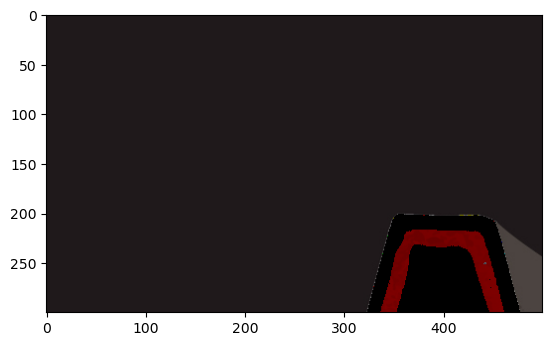

In [94]:
import matplotlib.pyplot as plt
plt.imshow(r)

In [65]:
df.x.max()

499

In [83]:
r

array([[[31, 31, 31],
        [31, 31, 31],
        [31, 31, 31],
        ...,
        [31, 31, 31],
        [31, 31, 31],
        [31, 31, 31]],

       [[31, 31, 31],
        [31, 31, 31],
        [31, 31, 31],
        ...,
        [31, 31, 31],
        [31, 31, 31],
        [31, 31, 31]],

       [[31, 31, 31],
        [31, 31, 31],
        [31, 31, 31],
        ...,
        [31, 31, 31],
        [31, 31, 31],
        [31, 31, 31]],

       ...,

       [[27, 27, 27],
        [27, 27, 27],
        [27, 27, 27],
        ...,
        [65, 65, 65],
        [65, 65, 65],
        [65, 65, 65]],

       [[27, 27, 27],
        [27, 27, 27],
        [27, 27, 27],
        ...,
        [65, 65, 65],
        [65, 65, 65],
        [65, 65, 65]],

       [[27, 27, 27],
        [27, 27, 27],
        [27, 27, 27],
        ...,
        [65, 65, 65],
        [65, 65, 65],
        [65, 65, 65]]])